In [118]:
reset -fs

In [119]:
import praw
import pandas as pd
import requests
import json
import csv
import re
import string
import numpy as np
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import gensim

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.stem.lancaster import LancasterStemmer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import spacy
import en_core_web_sm
from spacy.lang.en import English

# Reddit data acquisition - PSAW

In [120]:
from psaw import PushshiftAPI

In [121]:
api = PushshiftAPI()

### NBA Subreddit submissions

In [122]:
submissions = api.search_submissions(subreddit='nba', limit=12000)
df_submissions = pd.DataFrame([submission.d_ for submission in submissions])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


In [149]:
df_submissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10228 entries, 0 to 11978
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  10228 non-null  object 
 1   allow_live_comments            10228 non-null  bool   
 2   author                         10228 non-null  object 
 3   author_flair_background_color  5807 non-null   object 
 4   author_flair_css_class         5732 non-null   object 
 5   author_flair_richtext          10046 non-null  object 
 6   author_flair_template_id       4952 non-null   object 
 7   author_flair_text              5732 non-null   object 
 8   author_flair_text_color        5945 non-null   object 
 9   author_flair_type              10046 non-null  object 
 10  author_fullname                10046 non-null  object 
 11  author_is_blocked              10228 non-null  bool   
 12  author_patreon_flair           10046 non-null 

In [123]:
df_submissions[['title', 'selftext', 'created_utc']]

,title,selftext,created_utc
0,"In 378 minutes with Doncic on the floor, the M...",Kind of a weird stat. Luka's on-off is terrib...,1636673824
1,"In 378 minutes with Doncic on the floor, the M...",[deleted],1636673761
2,Could a Dame-for-Towns (+ any draft capital) s...,,1636673578
3,Did I wake up in the wrong universe? Frank Kam...,,1636673359
4,Will Barton is currently top 10 in Box plus/mi...,Note: Take Box plus/minus with a pinch of salt...,1636673166
...,...,...,...
11974,"[Highlight] Caruso says ""fuck your lob""",,1634346770
11975,[request] Caruso stopping a 2 on 1 fast break ...,He did it in the first quarter by swatting an ...,1634346537
11976,Would you be in favour of the league being abl...,Let´s say some players developed new moves dur...,1634346222
11977,Why aren't the Cavs spooky?,Jarret Allen. Lauri Markannen. Darius Garland....,1634346217


In [124]:
from datetime import datetime
dt = datetime.fromtimestamp(df_submissions.created_utc[11977]).strftime('%Y-%m-%d %H:%M:%S')
dt

'2021-10-15 21:03:37'

In [125]:
df_submissions.link_flair_text.value_counts()

Highlight                                                           1321
News                                                                 342
Post Game Thread                                                     205
Game Thread                                                          173
Original Content                                                      29
Index Thread                                                          26
Discussion                                                            26
Self-Promo and Fan Art Thread                                          3
No Audio                                                               1
Announcement                                                           1
Filler Text                                                            1
See Rule 1d. Joke Posts                                                1
Reaction post, lazy-self post                                          1
Tweets are News Only                               

In [126]:
df_submissions = df_submissions[(df_submissions.link_flair_text != 'Highlight') & 
                                (df_submissions.link_flair_text != 'Post Game Thread') & 
                                (df_submissions.link_flair_text != 'Game Thread') &
                                (df_submissions.link_flair_text != 'Discussion') &
                                (df_submissions.link_flair_text != 'Index Thread')]

#highlight
#post game thread
#game thread
#discussion
#index thread

In [153]:
df_subset = df_submissions[['author','author_flair_text','score','num_comments','title', 'selftext', 'created_utc']]
df_subset['doc_raw'] = df_subset['title'] + df_subset['selftext']
df_subset = df_subset.astype(str)
df_subset

/var/folders/fg/2wljsn7j2y9dmk_b4jk02j8r0000gn/T/ipykernel_26333/3241618234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['doc_raw'] = df_subset['title'] + df_subset['selftext']


,author,author_flair_text,score,num_comments,title,selftext,created_utc,doc_raw
0,PoEaDDict123,Bucks,2,0,"In 378 minutes with Doncic on the floor, the M...",Kind of a weird stat. Luka's on-off is terrib...,1636673824,"In 378 minutes with Doncic on the floor, the M..."
1,[deleted],None,1,0,"In 378 minutes with Doncic on the floor, the M...",[deleted],1636673761,"In 378 minutes with Doncic on the floor, the M..."
2,StatandMelo,Knicks,1,0,Could a Dame-for-Towns (+ any draft capital) s...,,1636673578,Could a Dame-for-Towns (+ any draft capital) s...
3,Danny886,:nba-1: NBA,1,0,Did I wake up in the wrong universe? Frank Kam...,,1636673359,Did I wake up in the wrong universe? Frank Kam...
4,Claustecter1015,:den-1: Nuggets,1,0,Will Barton is currently top 10 in Box plus/mi...,Note: Take Box plus/minus with a pinch of salt...,1636673166,Will Barton is currently top 10 in Box plus/mi...
...,...,...,...,...,...,...,...,...
11973,Otherwise_Window,:gsw-1: Warriors,1,43,The first detailed study of the long-term effe...,I think this is relevant to discussions of the...,1634346788,The first detailed study of the long-term effe...
11975,lolq12345,None,1,30,[request] Caruso stopping a 2 on 1 fast break ...,He did it in the first quarter by swatting an ...,1634346537,[request] Caruso stopping a 2 on 1 fast break ...
11976,Re4ch,:dal-2: Mavericks,1,10,Would you be in favour of the league being abl...,Let´s say some players developed new moves dur...,1634346222,Would you be in favour of the league being abl...
11977,10153--35101,None,1,63,Why aren't the Cavs spooky?,Jarret Allen. Lauri Markannen. Darius Garland....,1634346217,Why aren't the Cavs spooky?Jarret Allen. Lauri...


In [155]:
df = df_subset.groupby(['author','author_flair_text']).agg({'score':'sum','num_comments':'sum','doc_raw':'sum'}).reset_index()
df

,author,author_flair_text,score,num_comments,doc_raw
0,-FlapjacK-,:orl-1: Magic,1,1,Cole Anthony’s last 4 games 22.3/8.8/6.0 on 51...
1,-HeisenBird-,:tor-4: Raptors,1,30,"As we all expected, the top 4 seeds in the Eas..."
2,-Inverted-,None,11,02,Is it legal to stop dribbling and than start a...
3,-Jfree-,24,11,19142,How did the 93-94 Bulls manage to win 55 games...
4,-LeBronto-,None,1,1,"In honor of the new season starting today, whi..."
...,...,...,...,...,...
4485,znewking,None,1,5,"Raptors Game LiveHello,\n\nI'm interested in w..."
4486,zonexgamer,None,1,0,"Yes , no , maybe..."
4487,zoom25,None,1,0,Today is the 1st of the month. Please give you...
4488,zuesosaurus,None,1,264,I was watching the ‘92 Bulls vs Heat game and ...


In [156]:
df['body'] = df['doc_raw']
df

,author,author_flair_text,score,num_comments,doc_raw,body
0,-FlapjacK-,:orl-1: Magic,1,1,Cole Anthony’s last 4 games 22.3/8.8/6.0 on 51...,Cole Anthony’s last 4 games 22.3/8.8/6.0 on 51...
1,-HeisenBird-,:tor-4: Raptors,1,30,"As we all expected, the top 4 seeds in the Eas...","As we all expected, the top 4 seeds in the Eas..."
2,-Inverted-,None,11,02,Is it legal to stop dribbling and than start a...,Is it legal to stop dribbling and than start a...
3,-Jfree-,24,11,19142,How did the 93-94 Bulls manage to win 55 games...,How did the 93-94 Bulls manage to win 55 games...
4,-LeBronto-,None,1,1,"In honor of the new season starting today, whi...","In honor of the new season starting today, whi..."
...,...,...,...,...,...,...
4485,znewking,None,1,5,"Raptors Game LiveHello,\n\nI'm interested in w...","Raptors Game LiveHello,\n\nI'm interested in w..."
4486,zonexgamer,None,1,0,"Yes , no , maybe...","Yes , no , maybe..."
4487,zoom25,None,1,0,Today is the 1st of the month. Please give you...,Today is the 1st of the month. Please give you...
4488,zuesosaurus,None,1,264,I was watching the ‘92 Bulls vs Heat game and ...,I was watching the ‘92 Bulls vs Heat game and ...


In [157]:
import contractions
def preprocess(df, column):
    #fix contracted words  
    apostrophe = lambda x: contractions.fix(x)
    df[column] = df[column].map(apostrophe)

    #ensure alphanumeric only
    alphanumeric = lambda x: re.sub('[^a-zA-Z]',' ', x)
    #remove lower case
    lower_case = lambda x: x.lower()
    #remove newline
    new_line = lambda x: x.replace('\n', '')
    df[column] = df[column].map(alphanumeric).map(lower_case).map(new_line)
    
    #remove extra spaces
    spaces = lambda x: x.replace('  ', ' ')
    df[column] = df[column].map(spaces)
    
    df.body.replace('', np.nan, inplace = True) 
    df.dropna(subset = ['body'], inplace = True)
    return df

In [158]:
df = preprocess(df, 'body')
df

,author,author_flair_text,score,num_comments,doc_raw,body
0,-FlapjacK-,:orl-1: Magic,1,1,Cole Anthony’s last 4 games 22.3/8.8/6.0 on 51...,cole anthony s last games on sho...
1,-HeisenBird-,:tor-4: Raptors,1,30,"As we all expected, the top 4 seeds in the Eas...",as we all expected the top seeds in the east ...
2,-Inverted-,None,11,02,Is it legal to stop dribbling and than start a...,is it legal to stop dribbling and than start a...
3,-Jfree-,24,11,19142,How did the 93-94 Bulls manage to win 55 games...,how did the bulls manage to win games with...
4,-LeBronto-,None,1,1,"In honor of the new season starting today, whi...",in honor of the new season starting today whic...
...,...,...,...,...,...,...
4485,znewking,None,1,5,"Raptors Game LiveHello,\n\nI'm interested in w...",raptors game livehello i am interested in wat...
4486,zonexgamer,None,1,0,"Yes , no , maybe...",yes no maybe
4487,zoom25,None,1,0,Today is the 1st of the month. Please give you...,today is the st of the month please give your ...
4488,zuesosaurus,None,1,264,I was watching the ‘92 Bulls vs Heat game and ...,i was watching the bulls vs heat game and no...


In [404]:
pd.options.display.max_colwidth = 100

In [407]:
df['doc_raw'].head(2)

0    Cole Anthony’s last 4 games 22.3/8.8/6.0 on 51.6/48.1/80.0 shooting splits 64.9 TS% and a great ...
1    As we all expected, the top 4 seeds in the East after 5 games (in no order) are Knicks, Bulls, H...
Name: doc_raw, dtype: object

In [408]:
df['body'].head(2)

0                                   cole anthony  last                  splits   ts   great   net rating
1       expected  top  seeds   east      order  knicks bulls hornets  wizards let us assume        pl...
Name: body, dtype: object

In [319]:
from nltk.corpus import stopwords

#   Remove specific words that are not informative
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['www', 'https', 'http', 
                'com', 'day', 'yall', 
                'wh', 'tn', 'im', 've', 
                'mg', 's', 'nba', 'removed', 'amp', 
                'reddit', 'comments', 'subreddit', 'moderators', 
                'mod', 'game', 'team', 'teams', 'like', 'games', 'th',
                'player', 'players', 'season', 'gt', 'said', 
                'think', 'year', 'know', 'really', 'play', 'basketball', 
                'good', 'better', 'best', 'x200b', 'point', 'points', 'time', 
                'going', 'guys', 'years', 'people', 'got', 'make', 'tonight', 
                'win', 'new', 'ball', 'vs', 'career']

stopwords.extend(newStopWords)
custom_stopwords = stopwords.extend(newStopWords)
 
for word in stopwords:
    remove_word = lambda x: re.sub(r'\b'+word+r'\b', '', x)
    df.body = df.body.map(remove_word)

In [320]:
df

,author,author_flair_text,score,num_comments,doc_raw,body
0,-FlapjacK-,:orl-1: Magic,1,1,Cole Anthony’s last 4 games 22.3/8.8/6.0 on 51...,cole anthony last splits t...
1,-HeisenBird-,:tor-4: Raptors,1,30,"As we all expected, the top 4 seeds in the Eas...",expected top seeds east order kni...
2,-Inverted-,None,11,02,Is it legal to stop dribbling and than start a...,legal stop dribbling start bounce o...
3,-Jfree-,24,11,19142,How did the 93-94 Bulls manage to win 55 games...,bulls manage without jordan one ...
4,-LeBronto-,None,1,1,"In honor of the new season starting today, whi...",honor starting today fiasco find ...
...,...,...,...,...,...,...
4485,znewking,None,1,5,"Raptors Game LiveHello,\n\nI'm interested in w...",raptors livehello interested watching li...
4486,zonexgamer,None,1,0,"Yes , no , maybe...",yes maybe
4487,zoom25,None,1,0,Today is the 1st of the month. Please give you...,today st month please give respects cj m...
4488,zuesosaurus,None,1,264,I was watching the ‘92 Bulls vs Heat game and ...,watching bulls heat noticed often jor...


## Count Vectorizer

In [321]:
# def count_vect(df, column):
#     cv1 = CountVectorizer(stop_words= 'english', 
#                           max_features = 10000, 
#                           min_df = 3, max_df = 0.9)
#     df_fit = cv1.fit_transform(df['clean_doc'])
#     df_fit.toarray()
#     df = pd.DataFrame(df_fit.toarray(), columns=cv1.get_feature_names())
#     return df, cv1

In [322]:
C_Vec = CountVectorizer(stop_words= 'english', 
                      max_features = 10000, 
                      min_df = 5, max_df = 0.9)
df_CV_fit = C_Vec.fit_transform(df['body'])
df_CV_fit.toarray()
df_CV = pd.DataFrame(df_CV_fit.toarray(), columns=C_Vec.get_feature_names())

In [323]:
df_CV_fit.shape

(4490, 5460)

In [324]:
df_CV

,aaron,ab,aba,abdel,abdominal,abdul,abilities,ability,able,absence,...,yt,zach,zarba,zeke,zeller,zero,ziaire,zion,zone,zubac
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF

In [325]:
# def tfidf(df, column):
#     tfidf = TfidfVectorizer(stop_words='clean_doc', 
#                             max_features = 10000, 
#                             min_df = 3, max_df = 0.9)
#     df_tfidf_fit = tfidf.fit_transform(df['clean_doc'])
#     df_tfidf_fit.toarray()
#     df_tfidf = pd.DataFrame(df_tfidf_fit.toarray(), columns=tfidf.get_feature_names())
#     return df_tfidf, tfidf, tfidf.get_feature_names()

In [326]:
TFIDF_Vec = TfidfVectorizer(stop_words='english', 
                        max_features = 10000, 
                        min_df = 5, max_df = 0.9)
df_TFIDF_fit = TFIDF_Vec.fit_transform(df['body'])
df_TFIDF_fit.toarray()
df_TFIDF = pd.DataFrame(df_TFIDF_fit.toarray(), columns=TFIDF_Vec.get_feature_names())
feature_names = TFIDF_Vec.get_feature_names()

In [327]:
sums_TFIDF = df_TFIDF.sum()

In [328]:
df_TFIDF_fit

<4490x5460 sparse matrix of type '<class 'numpy.float64'>'
	with 154227 stored elements in Compressed Sparse Row format>

In [329]:
df_TFIDF

,aaron,ab,aba,abdel,abdominal,abdul,abilities,ability,able,absence,...,yt,zach,zarba,zeke,zeller,zero,ziaire,zion,zone,zubac
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Topic Modeling

In [145]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

## LSA - CV

In [246]:
for number in range(1,11):
    lsa = TruncatedSVD(number)
    lsa.fit_transform(df_CV)
    print(str(display_topics(lsa, feature_names, 10)) + '\n')


Topic  0
ppg, reb, ast, stl, league, blk, percentage, worst, rebounds, lakers
None


Topic  0
ppg, reb, ast, stl, league, blk, percentage, worst, rebounds, lakers

Topic  1
league, percentage, worst, twitter, status, rebounds, lakers, double, nd, assists
None


Topic  0
ppg, reb, ast, stl, league, blk, percentage, worst, rebounds, lakers

Topic  1
league, percentage, worst, twitter, status, rebounds, lakers, double, nd, assists

Topic  2
twitter, status, tweet, simmons, source, says, ben, want, right, way
None


Topic  0
ppg, reb, ast, stl, league, blk, percentage, worst, rebounds, lakers

Topic  1
league, percentage, worst, twitter, status, rebounds, lakers, double, nd, assists

Topic  2
twitter, status, tweet, simmons, source, says, ben, want, right, way

Topic  3
yes, angeles, los, lakers, san, antonio, spurs, chicago, boston, celtics
None


Topic  0
ppg, reb, ast, stl, league, blk, percentage, worst, rebounds, lakers

Topic  1
league, percentage, worst, twitter, status, rebounds, 

## LSA - TFIDF

In [247]:
for number in range(1,11):
    lsa = TruncatedSVD(number)
    lsa.fit_transform(df_TFIDF)
    print(str(display_topics(lsa, feature_names, 10)) + '\n')


Topic  0
lakers, simmons, league, ben, lebron, westbrook, vs, trade, curry, new
None


Topic  0
lakers, simmons, league, ben, lebron, westbrook, vs, trade, curry, new

Topic  1
pass, league, question, watch, fantasy, streaming, questions, tv, error, free
None


Topic  0
lakers, simmons, league, ben, lebron, westbrook, vs, trade, curry, new

Topic  1
pass, league, question, watch, fantasy, streaming, questions, error, tv, free

Topic  2
simmons, ben, pass, league, kyrie, sixers, ers, trade, mental, practice
None


Topic  0
lakers, simmons, league, ben, lebron, westbrook, vs, trade, curry, new

Topic  1
pass, league, question, watch, fantasy, streaming, questions, tv, error, angles

Topic  2
simmons, ben, pass, league, kyrie, sixers, ers, trade, mental, practice

Topic  3
lakers, lebron, westbrook, james, trade, ad, russell, harden, kyrie, russ
None


Topic  0
lakers, simmons, league, ben, lebron, westbrook, vs, trade, curry, new

Topic  1
pass, league, question, watch, fantasy, streami

## NMF - CV

In [248]:
for number in range(1,11):
    nmf = NMF(number)
    nmf.fit_transform(df_CV)
    print('components: ' + str(number) + ' ' + str(display_topics(nmf, feature_names, 10)) + '\n')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
ppg, reb, ast, stl, league, blk, percentage, worst, rebounds, lakers
components: 1 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
ppg, reb, ast, stl, blk, jr, anthony, jordan, johnson, jalen

Topic  1
league, percentage, worst, rebounds, twitter, status, lakers, double, nd, assists
components: 2 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
ppg, reb, ast, stl, blk, jr, anthony, jordan, johnson, jalen

Topic  1
league, percentage, worst, double, rebounds, nd, rd, assists, watch, injured

Topic  2
twitter, status, tweet, simmons, source, lakers, says, ben, want, new
components: 3 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
ppg, reb, ast, stl, blk, jr, anthony, jordan, johnson, jalen

Topic  1
league, percentage, worst, double, rebounds, nd, rd, assists, watch, injured

Topic  2
twitter, status, tweet, simmons, source, says, ben, want, league, right

Topic  3
yes, angeles, los, lakers, san, spurs, antonio, celtics, chicago, boston
components: 4 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
ppg, reb, ast, stl, blk, jr, anthony, johnson, jordan, jalen

Topic  1
league, percentage, worst, double, rebounds, nd, rd, assists, watch, injured

Topic  2
twitter, status, tweet, simmons, source, says, league, want, ben, right

Topic  3
yes, angeles, los, lakers, san, spurs, antonio, celtics, chicago, boston

Topic  4
box, stats, score, lebron, gameid, westbrook, lakers, vs, events, flag
components: 5 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
ppg, reb, ast, stl, blk, jr, anthony, johnson, jordan, jalen

Topic  1
league, percentage, worst, double, rebounds, nd, rd, assists, watch, injured

Topic  2
twitter, status, tweet, simmons, source, says, league, want, ben, right

Topic  3
yes, angeles, los, lakers, san, spurs, antonio, celtics, chicago, boston

Topic  4
stats, box, gameid, score, lebron, westbrook, events, flag, lakers, sct

Topic  5
lal, bkn, den, phx, mil, dal, uta, gsw, mia, phi
components: 6 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
ppg, reb, ast, stl, blk, jr, anthony, johnson, jordan, jalen

Topic  1
league, percentage, worst, double, rebounds, nd, rd, assists, watch, injured

Topic  2
twitter, status, tweet, simmons, source, says, league, want, ben, right

Topic  3
yes, angeles, los, lakers, san, spurs, antonio, celtics, chicago, boston

Topic  4
gameid, stats, events, flag, sct, plot, pts, title, westbrook, defense

Topic  5
score, box, lebron, vs, ts, harden, steph, kd, lakers, playoffs

Topic  6
lal, bkn, den, phx, mil, uta, dal, gsw, mia, phi
components: 7 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
ppg, reb, ast, stl, blk, jr, jordan, johnson, anthony, green

Topic  1
league, percentage, worst, double, rebounds, nd, rd, assists, watch, injured

Topic  2
twitter, status, tweet, simmons, source, says, league, want, ben, right

Topic  3
yes, angeles, los, lakers, san, spurs, antonio, celtics, chicago, boston

Topic  4
stats, gameid, flag, events, sct, plot, title, defense, westbrook, regular

Topic  5
score, box, lebron, vs, ts, harden, steph, kd, stats, playoffs

Topic  6
lal, bkn, den, phx, mil, uta, dal, gsw, mia, phi

Topic  7
pts, lakers, fg, espn, pf, source, anthony, boxscore, james, westbrook
components: 8 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
ppg, reb, ast, stl, blk, jr, jordan, johnson, anthony, green

Topic  1
league, percentage, worst, double, rebounds, nd, rd, assists, watch, injured

Topic  2
twitter, status, tweet, simmons, source, says, league, want, right, ben

Topic  3
yes, angeles, los, lakers, san, spurs, antonio, celtics, chicago, boston

Topic  4
stats, gameid, flag, events, sct, plot, title, defense, westbrook, regular

Topic  5
score, box, lebron, vs, ts, harden, steph, kd, stats, playoffs

Topic  6
lal, bkn, den, phx, mil, dal, uta, gsw, mia, phi

Topic  7
pts, fg, espn, lakers, source, boxscore, pf, gameid, ast, blk

Topic  8
ben, lock, great, kareem, playing, minutes, stays, finals, peak, list
components: 9 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
ppg, reb, ast, stl, blk, jr, jordan, johnson, anthony, green

Topic  1
league, percentage, worst, double, rebounds, nd, rd, assists, watch, injured

Topic  2
twitter, status, tweet, simmons, source, says, league, want, ben, right

Topic  3
yes, angeles, los, lakers, san, spurs, antonio, celtics, chicago, boston

Topic  4
stats, gameid, flag, events, sct, plot, title, defense, westbrook, regular

Topic  5
score, box, lebron, vs, ts, harden, steph, kd, stats, playoffs

Topic  6
lal, bkn, den, phx, mil, dal, uta, gsw, mia, phi

Topic  7
pts, fg, espn, lakers, source, boxscore, pf, gameid, ast, blk

Topic  8
lock, minutes, playing, roster, jr, great, fit, young, brown, start

Topic  9
kareem, finals, ben, stays, peak, list, scoring, magic, duncan, mvp
components: 10 None



## NMF - TFIDF

In [330]:
for number in range(1,16):
    nmf = NMF(number)
    nmf.fit_transform(df_TFIDF)
    print('components: ' + str(number) + ' ' + str(display_topics(nmf, feature_names, 10)) + '\n')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lakers, simmons, league, ben, lebron, westbrook, trade, curry, harden, pass
components: 1 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lakers, simmons, ben, lebron, westbrook, trade, curry, harden, james, kyrie

Topic  1
pass, league, question, fantasy, watch, questions, streaming, tv, error, bad
components: 2 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lakers, lebron, curry, westbrook, james, harden, warriors, jokic, steph, fg

Topic  1
pass, league, question, fantasy, watch, questions, streaming, tv, error, bad

Topic  2
simmons, ben, kyrie, sixers, ers, trade, irving, embiid, practice, mental
components: 3 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lakers, lebron, westbrook, harden, james, curry, warriors, steph, trade, nets

Topic  1
pass, league, question, fantasy, watch, questions, streaming, error, tv, bad

Topic  2
simmons, ben, kyrie, sixers, ers, trade, irving, embiid, practice, mental

Topic  3
jokic, pts, pf, fg, ast, morris, reb, stl, blk, nbsp
components: 4 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lakers, lebron, westbrook, harden, james, curry, warriors, steph, trade, nets

Topic  1
pass, league, question, fantasy, watch, questions, streaming, error, tv, bad

Topic  2
simmons, ben, kyrie, sixers, ers, trade, irving, practice, embiid, mental

Topic  3
pts, pf, fg, ast, stl, reb, blk, nbsp, ft, sg

Topic  4
jokic, morris, brothers, twitter, nikola, brother, marcus, markieff, tweet, account
components: 5 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lakers, warriors, westbrook, trade, start, bulls, watch, right, shot, nets

Topic  1
pass, league, question, fantasy, watch, questions, streaming, error, tv, angles

Topic  2
simmons, ben, kyrie, ers, sixers, trade, irving, practice, embiid, mental

Topic  3
pts, pf, fg, ast, stl, reb, blk, nbsp, ft, sg

Topic  4
jokic, morris, brothers, twitter, nikola, brother, marcus, markieff, tweet, account

Topic  5
lebron, james, harden, curry, list, steph, jordan, kyrie, kobe, kevin
components: 6 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
watch, warriors, bulls, knicks, shot, right, great, celtics, curry, minutes

Topic  1
pass, league, question, fantasy, watch, questions, streaming, error, tv, angles

Topic  2
simmons, ben, kyrie, ers, sixers, trade, irving, practice, mental, embiid

Topic  3
pf, pts, ast, fg, stl, blk, reb, nbsp, ft, sg

Topic  4
jokic, morris, brothers, nikola, twitter, brother, marcus, markieff, tweet, account

Topic  5
lebron, james, harden, curry, list, jordan, kyrie, kobe, steph, kevin

Topic  6
lakers, westbrook, trade, russell, ad, warriors, russ, lebron, nets, hield
components: 7 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
watch, warriors, bulls, shot, knicks, great, right, curry, celtics, minutes

Topic  1
pass, league, question, fantasy, watch, questions, streaming, error, tv, angles

Topic  2
simmons, ben, ers, sixers, trade, practice, mental, embiid, sources, situation

Topic  3
pf, pts, ast, fg, stl, blk, reb, nbsp, ft, sg

Topic  4
jokic, morris, brothers, nikola, twitter, brother, marcus, markieff, tweet, account

Topic  5
lebron, james, harden, curry, jordan, kobe, list, steph, kevin, kd

Topic  6
lakers, westbrook, trade, russell, ad, warriors, russ, lebron, nets, hield

Topic  7
kyrie, irving, nets, vaccine, list, brooklyn, trade, chris, vaccinated, westbrook
components: 8 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
curry, steph, list, jordan, paul, greatest, giannis, mvp, kevin, anthony

Topic  1
pass, league, question, fantasy, watch, questions, streaming, error, tv, angles

Topic  2
simmons, ben, ers, sixers, trade, practice, mental, embiid, sources, rivers

Topic  3
pf, pts, ast, fg, stl, blk, reb, nbsp, ft, sg

Topic  4
jokic, morris, brothers, nikola, twitter, brother, marcus, markieff, tweet, account

Topic  5
lebron, james, harden, kd, ad, dunk, kobe, free, mj, nft

Topic  6
lakers, westbrook, trade, russell, ad, warriors, russ, hield, melo, nets

Topic  7
kyrie, irving, nets, vaccine, brooklyn, harden, trade, list, vaccinated, kd

Topic  8
watch, bulls, knicks, celtics, right, great, want, playing, fans, shot
components: 9 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"



Topic  0
assists, minutes, shot, rebounds, defense, right, free, start, far, great

Topic  1
pass, league, question, fantasy, watch, questions, streaming, error, tv, angles

Topic  2
simmons, ben, ers, sixers, trade, practice, mental, embiid, situation, sources

Topic  3
pf, pts, ast, fg, stl, blk, nbsp, reb, sg, ft

Topic  4
jokic, morris, brothers, nikola, twitter, brother, marcus, markieff, tweet, account

Topic  5
lebron, james, harden, kd, ad, dunk, kobe, mj, nft, washed

Topic  6
lakers, westbrook, trade, russell, ad, russ, warriors, hield, melo, bad

Topic  7
kyrie, irving, nets, vaccine, brooklyn, trade, harden, vaccinated, kd, list

Topic  8
bulls, knicks, heat, watch, warriors, celtics, east, bucks, nets, fans

Topic  9
curry, steph, list, jordan, paul, greatest, giannis, mvp, kevin, kobe
components: 10 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
bulls, knicks, celtics, assists, minutes, right, defense, rebounds, great, playing

Topic  1
pass, league, question, fantasy, questions, error, angles, bad, streaming, quality

Topic  2
simmons, ben, ers, sixers, trade, practice, mental, embiid, situation, rivers

Topic  3
pf, pts, ast, fg, stl, blk, nbsp, reb, sg, ft

Topic  4
jokic, morris, brothers, nikola, twitter, brother, marcus, markieff, tweet, account

Topic  5
lebron, james, harden, kd, ad, dunk, free, kobe, jordan, mj

Topic  6
lakers, westbrook, trade, russell, ad, warriors, russ, hield, melo, nets

Topic  7
kyrie, irving, nets, vaccine, brooklyn, harden, trade, kd, vaccinated, right

Topic  8
watch, want, fan, youtube, fans, watching, way, help, live, tv

Topic  9
curry, steph, warriors, jordan, stephen, quarter, klay, prime, triple, poole

Topic  10
list, anthony, paul, dwight, greatest, giannis, kevin, howard, kobe, malone
components: 11 None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
assists, minutes, rebounds, defense, shot, right, far, draft, great, luka

Topic  1
pass, league, question, fantasy, questions, error, angles, bad, streaming, quality

Topic  2
simmons, ben, ers, sixers, trade, practice, mental, embiid, situation, rivers

Topic  3
pf, pts, ast, stl, fg, blk, nbsp, reb, sg, ft

Topic  4
jokic, morris, brothers, nikola, twitter, brother, marcus, markieff, tweet, account

Topic  5
lebron, james, harden, kd, ad, dunk, kobe, jordan, mj, nft

Topic  6
lakers, westbrook, trade, russell, ad, russ, warriors, hield, melo, bad

Topic  7
kyrie, irving, nets, vaccine, brooklyn, trade, harden, kd, vaccinated, right

Topic  8
bulls, knicks, heat, celtics, warriors, east, bucks, nets, jazz, chicago

Topic  9
list, anthony, dwight, paul, greatest, giannis, kevin, howard, kobe, malone

Topic  10
curry, steph, warriors, stephen, jordan, quarter, klay, prime, triple, poole

Topic  11
watch, want, fan, youtube, fans, way, watching, help, live, tv
components: 12 N

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
bulls, knicks, celtics, right, heat, trade, bucks, playing, raptors, great

Topic  1
pass, league, question, fantasy, questions, error, angles, bad, streaming, buy

Topic  2
simmons, ben, ers, sixers, trade, practice, mental, embiid, rivers, sources

Topic  3
pf, pts, ast, stl, blk, nbsp, reb, sg, sf, min

Topic  4
jokic, morris, brothers, nikola, twitter, brother, marcus, markieff, tweet, account

Topic  5
lebron, james, ad, jordan, kobe, mj, kd, dunk, kuzma, ending

Topic  6
lakers, westbrook, trade, russell, ad, warriors, russ, hield, melo, buddy

Topic  7
kyrie, irving, nets, vaccine, brooklyn, vaccinated, right, kd, trade, chris

Topic  8
list, anthony, paul, dwight, greatest, kevin, howard, giannis, davis, kobe

Topic  9
espn, assists, rebounds, fg, minutes, gameid, steals, boxscore, pts, source

Topic  10
curry, steph, warriors, jordan, stephen, klay, quarter, prime, poole, shot

Topic  11
watch, want, youtube, fan, live, watching, help, way, fans, video

Topic  12
har

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
trade, right, draft, zion, luka, star, great, playing, defense, pick

Topic  1
pass, league, question, fantasy, questions, error, angles, bad, streaming, buy

Topic  2
simmons, ben, ers, sixers, trade, practice, mental, embiid, situation, rivers

Topic  3
pf, pts, ast, stl, blk, nbsp, reb, sg, sf, min

Topic  4
jokic, morris, brothers, nikola, markieff, brother, marcus, nuggets, dirty, account

Topic  5
lebron, james, ad, kobe, mj, jordan, dunk, kd, kuzma, ending

Topic  6
lakers, westbrook, russell, trade, ad, russ, warriors, hield, melo, buddy

Topic  7
kyrie, irving, nets, vaccine, brooklyn, vaccinated, chris, westbrook, right, list

Topic  8
curry, steph, list, jordan, paul, greatest, kevin, kobe, dwight, giannis

Topic  9
assists, rebounds, espn, fg, minutes, gameid, steals, boxscore, pts, pt

Topic  10
bulls, warriors, knicks, heat, celtics, jazz, east, chicago, nets, bucks

Topic  11
watch, want, youtube, fan, live, watching, fans, help, way, tv

Topic  12
harden, jame

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
right, draft, trade, luka, zion, star, great, defense, playing, pick

Topic  1
pass, league, question, fantasy, questions, error, angles, bad, streaming, buy

Topic  2
simmons, ben, ers, sixers, trade, practice, mental, embiid, situation, rivers

Topic  3
pf, pts, ast, stl, blk, nbsp, reb, sg, sf, min

Topic  4
jokic, morris, brothers, nikola, markieff, brother, marcus, nuggets, dirty, account

Topic  5
lebron, james, ad, kobe, mj, jordan, dunk, kd, kuzma, ending

Topic  6
lakers, ad, warriors, russ, nets, start, melo, home, hield, look

Topic  7
kyrie, irving, nets, vaccine, brooklyn, vaccinated, list, chris, right, wrong

Topic  8
curry, steph, list, jordan, paul, greatest, kevin, kobe, george, dwight

Topic  9
assists, espn, rebounds, fg, minutes, gameid, steals, boxscore, pts, pt

Topic  10
bulls, knicks, warriors, heat, celtics, chicago, jazz, east, bucks, hornets

Topic  11
watch, want, youtube, fan, live, watching, fans, help, way, tv

Topic  12
harden, james, free, fo

## LDA - CV

In [341]:
for number in range(1,11):
    lda = LatentDirichletAllocation(number)
    lda.fit_transform(df_CV)
    print('components: ' + str(number) + str(display_topics(lda, feature_names, 10)) + '\n')


Topic  0
league, lakers, simmons, lebron, ppg, ben, twitter, warriors, reb, ast
components: 1None


Topic  0
simmons, lebron, ben, twitter, lakers, league, status, trade, want, way

Topic  1
league, ppg, reb, ast, lakers, pts, stats, fg, minutes, assists
components: 2None


Topic  0
reb, twitter, ast, status, simmons, ppg, pts, stl, espn, ben

Topic  1
league, lakers, lebron, minutes, harden, shot, assists, defense, rebounds, westbrook

Topic  2
lakers, ben, simmons, lebron, warriors, list, trade, finals, league, kyrie
components: 3None


Topic  0
reb, ppg, ast, stl, twitter, green, status, jr, warriors, source

Topic  1
simmons, ben, lebron, league, twitter, trade, want, lakers, way, jokic

Topic  2
list, lakers, finals, celtics, bulls, kobe, warriors, spurs, mvp, kareem

Topic  3
league, stats, fg, lakers, pts, assists, rebounds, minutes, pf, box
components: 4None


Topic  0
lakers, lebron, league, westbrook, harden, curry, great, defense, steph, far

Topic  1
watch, free, imgur, tr

## LDA - TFIDF

In [342]:
for number in range(1,11):
    lda = LatentDirichletAllocation(number)
    lda.fit_transform(df_TFIDF)
    print('components: ' + str(number) + str(display_topics(lda, feature_names, 10)) + '\n')


Topic  0
league, lakers, simmons, lebron, ben, jokic, pass, kyrie, curry, westbrook
components: 1None


Topic  0
league, pass, jokic, pts, fg, morris, assists, lakers, twitter, raptors

Topic  1
simmons, ben, lebron, lakers, kyrie, westbrook, trade, curry, league, fans
components: 2None


Topic  0
lakers, lebron, jokic, league, westbrook, curry, trade, harden, way, simmons

Topic  1
jerseys, list, kobe, watch, kareem, shaq, streaming, jersey, anniversary, edition

Topic  2
pass, league, simmons, ben, kyrie, pf, irving, twitter, says, sources
components: 3None


Topic  0
james, lebron, harden, jordan, kyrie, list, watch, kanter, giannis, free

Topic  1
jerseys, jersey, support, city, clip, edition, timeout, help, covid, request

Topic  2
league, lakers, pass, westbrook, lebron, bulls, trade, warriors, jokic, curry

Topic  3
simmons, ben, kyrie, jokic, fantasy, irving, ers, klay, twitter, morris
components: 4None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: 


Topic  0
lakers, simmons, league, jokic, lebron, trade, curry, harden, ben, want

Topic  1
ben, simmons, kyrie, league, pass, westbrook, support, williamson, zion, jefferson

Topic  2
league, pass, list, lebron, fantasy, dwight, james, kobe, jordan, greatest

Topic  3
pts, fg, pf, ast, reb, josh, anthony, boxscore, box, sg

Topic  4
pass, league, app, morris, sarver, foul, streams, unpopular, suns, streaming
components: 5None


Topic  0
morris, jerseys, clip, request, markieff, foul, city, edition, bulls, jokic

Topic  1
simmons, ben, kyrie, list, irving, league, watch, fantasy, espn, trade

Topic  2
lakers, league, lebron, jokic, curry, warriors, pass, westbrook, harden, way

Topic  3
kanter, enes, stream, free, opinion, unpopular, lebron, highlights, shoes, giannis

Topic  4
pf, josh, giddey, sg, stl, nbsp, uk, blk, sf, ast

Topic  5
zion, support, williamson, boy, logo, bagley, chess, text, talk, podcasts
components: 6None


Topic  0
lakers, westbrook, curry, list, league, steph, h

## pyLDAvis

In [33]:
# #C_Vec
# tf_vectorizer = CountVectorizer(stop_words= 'english', 
#                           max_features = 10000, 
#                           min_df = 3, max_df = 0.9)
# #df_CV_fit = C_Vec.fit_transform(df['clean_doc'])
# dtm_tf = tf_vectorizer.fit_transform(df['clean_doc'])
# print(dtm_tf.shape)

In [34]:
# #TFIDF_Vec
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
#                             max_features = 10000, 
#                             min_df = 3, max_df = 0.9)
# #df_TFIDF_fit = TFIDF_Vec.fit_transform(df['clean_doc'])
# dtm_tfidf = tfidf_vectorizer.fit_transform(df['clean_doc'])
# print(dtm_tfidf.shape)

In [343]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [344]:
# for CV 
lda_TF = LatentDirichletAllocation(n_components=5, random_state=0)
lda_TF.fit(df_CV_fit)

LatentDirichletAllocation(n_components=5, random_state=0)

In [345]:
pyLDAvis.sklearn.prepare(lda_TF, df_CV_fit, C_Vec)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.136204  0.008512       1        1  35.713122
3      0.113425  0.069746       2        1  28.091025
0      0.001282 -0.210192       3        1  13.814397
4     -0.259859  0.037132       4        1  11.793879
1      0.008948  0.094802       5        1  10.587577, topic_info=         Term         Freq        Total Category  logprob  loglift
3664      ppg   954.000000   954.000000  Default  30.0000  30.0000
3890      reb   791.000000   791.000000  Default  29.0000  29.0000
292       ast   758.000000   758.000000  Default  28.0000  28.0000
4416  simmons  1164.000000  1164.000000  Default  27.0000  27.0000
2707   league  1706.000000  1706.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
2722   lebron   128.410556  1153.151538   Topic5  -5.3927   0.0505
4627   status   115.785735   740.696256   Topic5  -5.4962   0.3896
3254    night   111.018919   540.784798   Topic5  -5.5382   0.6622
1963  giannis   101.607214   444.350255   Topic5  -5.6268   0.7700
4380    shots    97.975025   415.878809   Topic5  -5.6632   0.7998

[392 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5         2  0.034648    abdul
5         3  0.952808    abdul
58        1  0.692964       ad
58        2  0.091839       ad
58        3  0.091839       ad
...     ...       ...      ...
5436      3  0.007830      yes
5447      1  0.867098  youtube
5447      2  0.072258  youtube
5447      3  0.056201  youtube
5449      5  0.925921      yrs

[992 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

In [334]:
# for TFIDF 
lda_TFIDF = LatentDirichletAllocation(n_components=8, random_state=0)
lda_TFIDF.fit(df_TFIDF_fit)

LatentDirichletAllocation(n_components=8, random_state=0)

In [335]:
pyLDAvis.sklearn.prepare(lda_TFIDF, df_TFIDF_fit, TFIDF_Vec)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.121801 -0.051550       1        1  29.155063
5      0.126790  0.068959       2        1  25.250295
0      0.028936  0.030506       3        1  16.417961
6     -0.015802 -0.145133       4        1  10.635879
7     -0.036886  0.026858       5        1   4.951433
4     -0.088768  0.002661       6        1   4.831479
1     -0.082358  0.027135       7        1   4.501854
2     -0.053713  0.040565       8        1   4.256036, topic_info=           Term       Freq      Total Category  logprob  loglift
2502      jokic  36.000000  36.000000  Default  30.0000  30.0000
3135     morris  18.000000  18.000000  Default  29.0000  29.0000
2635      kyrie  33.000000  33.000000  Default  28.0000  28.0000
1702    fantasy  10.000000  10.000000  Default  27.0000  27.0000
2419     irving  17.000000  17.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
4416    simmons   2.029205  60.042685   Topic8  -5.9456  -0.2306
1386      draft   1.745473  21.287924   Topic8  -6.0962   0.6557
3215       need   1.713988  18.886431   Topic8  -6.1144   0.7572
5329  westbrook   1.636326  35.618856   Topic8  -6.1608   0.0764
2909        man   1.597190  22.483731   Topic8  -6.1850   0.5123

[502 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5         3  0.442937    abdul
5         7  0.442937    abdul
25        1  0.281795  account
25        6  0.563590  account
87        4  0.322231      ads
...     ...       ...      ...
5451      4  0.782940     zach
5457      1  0.553963     zion
5457      2  0.110793     zion
5457      5  0.166189     zion
5457      8  0.166189     zion

[1038 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 1, 7, 8, 5, 2, 3])

## Model Choice

In [359]:
NMF_final = NMF(n_components=8)
df_topic = NMF_final.fit_transform(df_TFIDF_fit)
nmf_topics_by_post = pd.DataFrame(df_topic, index = df['body'], 
                                  columns = ['Top_Teams', 'Streaming', 'Ben_Simmons', 'Lakers',
                                            'Jokic/Morris', 'GOAT/75List', 'Stats', 'Kyrie_Irving'])
nmf_topics_by_post['Main_Topic'] = nmf_topics_by_post.idxmax(axis=1)
nmf_topics_by_post.head()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


,Top_Teams,Streaming,Ben_Simmons,Lakers,Jokic/Morris,GOAT/75List,Stats,Kyrie_Irving,Main_Topic
body,,,,,,,,,
cole anthony last splits ts great net rating,0.027395,0.0,0.000000,0.004980,0.0,0.006416,0.000000,0.000000,Top_Teams
expected top seeds east order knicks bulls hornets wizards let us assume playoffs along bucks nets leaves playoff spots celtics hawks heat ers east playoff race bloodbath,0.058248,0.0,0.002338,0.001927,0.0,0.000000,0.001573,0.010064,Top_Teams
legal stop dribbling start bounce one body parts others chest specifically legal stop dribbling start bounce part body chest specifically,0.011441,0.0,0.000000,0.000000,0.0,0.000000,0.001231,0.000527,Top_Teams
bulls manage without jordan one surprising facts suddenly without goat trade compensation bulls outside jordan pippen leading scorer ppg trying imagine warriors playing without curry lebron without cannot see kind success supposed shot jordan young watched back would love insight would rather left list snubbed list reason asking accolade mean much overall mvp selection honestly would rather dwight see fans say sure ad dame situation saying joke made,0.059207,0.0,0.004350,0.000000,0.0,0.070516,0.006581,0.007641,GOAT/75List
honor starting today fiasco find entertaining,0.014929,0.0,0.002955,0.000000,0.0,0.002271,0.000000,0.000000,Top_Teams


In [360]:
topics_ordered = pd.DataFrame(nmf_topics_by_post.Main_Topic.value_counts()).reset_index()
topics_ordered.columns = ['Topic','Count']
topics_ordered
#Top_Teams topic overwhelmingly dominant. This is kind of a catchall that doesn't fit into any of the remaining categories

,Topic,Count
0,Top_Teams,2403
1,GOAT/75List,556
2,Ben_Simmons,308
3,Streaming,278
4,Jokic/Morris,258
5,Stats,250
6,Lakers,234
7,Kyrie_Irving,203


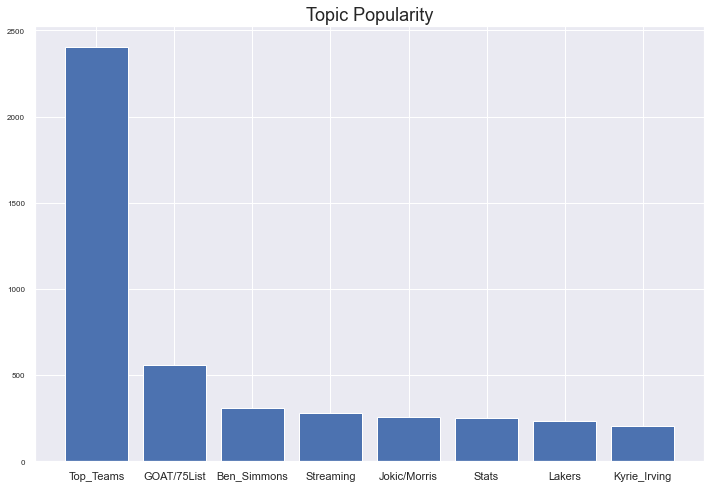

In [399]:
plt.bar(x=topics_ordered.Topic, height=topics_ordered.Count)
plt.title('Topic Popularity', fontsize = 18)
plt.yticks(size=8)
plt.show()

In [386]:
GOAT_75_only = nmf_topics_by_post[(nmf_topics_by_post['Main_Topic']== 'GOAT/75List')].sort_values(['GOAT/75List'], ascending=False).reset_index().head(10)

In [388]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [397]:
def create_wordcloud(wordcloud_series):
    df_text = ' '.join(str(wordcloud_series).lower() for v in wordcloud_series)
    wordcloud = WordCloud(stopwords = ["Lebron", "James", 'trinidad'], random_state = 20, background_color = 'white',
                      collocations=True).generate(df_text)
    plt.imshow(wordcloud, interpolation='bilInear')
    plt.axis('off')
    plt.show()

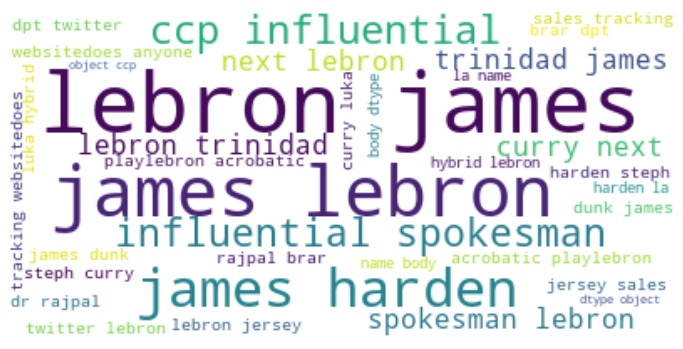

In [391]:
create_wordcloud(GOAT_75_only['body'])

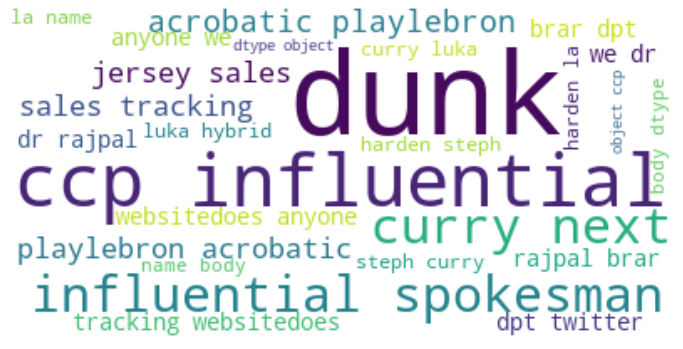

In [398]:
create_wordcloud(GOAT_75_only['body'])

# Goat/75 Only Dataset

In [369]:
# Create a GOAT/75List only dataset
df_TFIDF.index = nmf_topics_by_post.index

In [371]:
df_TFIDF['Main_Topic'] = nmf_topics_by_post['Main_Topic']

In [373]:
df_GOAT_75 = df_TFIDF[df_TFIDF.Main_Topic == 'GOAT/75List']

In [409]:
df_GOAT_75.shape

(556, 5460)

In [374]:
# df_experiences.drop('major_topic', axis = 1, inplace = True)
df_GOAT_75.drop('Main_Topic', axis = 1, inplace = True)
df_GOAT_75.head()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,aaron,ab,aba,abdel,abdominal,abdul,abilities,ability,able,absence,...,yt,zach,zarba,zeke,zeller,zero,ziaire,zion,zone,zubac
body,,,,,,,,,,,,,,,,,,,,,
bulls manage without jordan one surprising facts suddenly without goat trade compensation bulls outside jordan pippen leading scorer ppg trying imagine warriors playing without curry lebron without cannot see kind success supposed shot jordan young watched back would love insight would rather left list snubbed list reason asking accolade mean much overall mvp selection honestly would rather dwight see fans say sure ad dame situation saying joke made,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lebron james tears see one man knock boy ate lemon heads walking court,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
brad wanamaker look larry cucumber,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
would charles barkley todays,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
los angeles lakers working trade send lebron james miami heat st round picks kyle lowry memphis resident grizzlies need relocate nashville love grizzlies multiple every single believe deserve city fan support memphis care never life met die hard memphis grizzlies fan yeah get hot stretch come crawling old crinkly reebok grizz jersey never true superstar probably never conley cold mean come mike conley superstar humble quiet dude alright gasols cool went left get rings fine grit n grind era zbo tony allen etc hype us ended fast nothing show grizzlies never household name market small ugly boring dangerous fedex forum decent arena many complaints honest pretty generic fan attendance atrocious would shocked last league even k owner needs find way get rolling move nashville kansas city st louis hate say memphis cannot support james harden shaves beardit needs go feel would confuse many first beard calling shaveit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## NMF on Goat/75 Only

In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [376]:
for number in range(1,11):
    nmf = NMF(number)
    nmf.fit_transform(df_GOAT_75)
    print('components' + str(number) + str(display_topics(nmf, feature_names, 10)) + '\n')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lebron, james, harden, curry, jordan, list, kobe, steph, kd, kevin
components1None


Topic  0
lebron, james, harden, kd, lakers, curry, free, westbrook, ad, dunk

Topic  1
list, jordan, curry, kobe, kevin, paul, greatest, steph, malone, kareem
components2None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lebron, james, lakers, kd, mj, ad, curry, dunk, jordan, kuzma

Topic  1
list, curry, jordan, kobe, kevin, paul, greatest, malone, steph, anthony

Topic  2
harden, james, free, washed, throws, foul, changes, rule, kd, nets
components3None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lebron, james, lakers, kd, mj, ad, dunk, kuzma, ending, westbrook

Topic  1
list, greatest, kevin, paul, anthony, malone, bob, kobe, dave, dwight

Topic  2
harden, james, free, washed, throws, foul, changes, rule, nets, twitter

Topic  3
curry, jordan, steph, prime, stephen, kobe, michael, shaq, kd, durant
components4None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lebron, james, lakers, kd, mj, ad, kuzma, dunk, ending, kobe

Topic  1
kevin, kobe, paul, malone, kareem, bob, dave, george, bryant, jerry

Topic  2
harden, james, free, washed, throws, foul, changes, rule, nets, kd

Topic  3
curry, steph, jordan, prime, stephen, michael, shaq, kd, durant, giannis

Topic  4
list, greatest, dwight, carmelo, howard, anthony, remove, davis, believe, replace
components5None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lebron, james, lakers, kd, ad, mj, kuzma, ending, dunk, westbrook

Topic  1
kevin, paul, malone, bob, dave, george, kareem, anthony, jerry, durant

Topic  2
harden, james, free, washed, throws, foul, changes, rule, kd, nets

Topic  3
jordan, kobe, michael, bryant, kareem, mj, hakeem, poole, bird, kd

Topic  4
list, greatest, dwight, carmelo, howard, anthony, remove, davis, believe, replace

Topic  5
curry, steph, stephen, prime, shaq, durant, seth, george, kd, real
components6None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lebron, james, lakers, ad, kuzma, ending, dunk, kd, westbrook, mj

Topic  1
kevin, paul, malone, bob, dave, george, anthony, jerry, durant, allen

Topic  2
harden, james, free, washed, throws, foul, changes, rule, kd, nets

Topic  3
kobe, bryant, kareem, mj, kd, bird, shaq, wilt, bodyarmor, ts

Topic  4
list, greatest, dwight, carmelo, howard, anthony, remove, davis, replace, believe

Topic  5
curry, steph, stephen, prime, shaq, durant, seth, george, paul, real

Topic  6
jordan, michael, poole, hakeem, nike, gay, rant, jesus, goat, shorts
components7None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lebron, james, lakers, kuzma, ending, dunk, squid, kyle, takes, nft

Topic  1
kevin, paul, malone, bob, dave, george, anthony, jerry, durant, allen

Topic  2
harden, james, washed, free, foul, throws, changes, rule, planting, twitter

Topic  3
kd, giannis, prime, finals, wins, harden, nets, mj, ad, westbrook

Topic  4
list, greatest, dwight, carmelo, howard, anthony, remove, replace, davis, believe

Topic  5
curry, steph, stephen, prime, seth, shaq, george, paul, durant, shooter

Topic  6
jordan, michael, poole, hakeem, nike, gay, rant, jesus, shorts, goat

Topic  7
kobe, bryant, kareem, bird, mj, shaq, wilt, bodyarmor, cola, coca
components8None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lebron, james, lakers, kuzma, ending, dunk, squid, kyle, nft, takes

Topic  1
kevin, paul, malone, bob, george, dave, jerry, kareem, durant, jabbar

Topic  2
harden, james, washed, free, foul, throws, changes, rule, planting, twitter

Topic  3
kd, giannis, prime, finals, mj, nets, wins, harden, larry, mvp

Topic  4
list, greatest, remove, carmelo, believe, replace, anniversary, reaction, dwight, using

Topic  5
curry, steph, stephen, prime, seth, shaq, george, paul, durant, shooter

Topic  6
jordan, michael, poole, hakeem, nike, gay, rant, jesus, shorts, goat

Topic  7
kobe, bryant, kareem, bird, mj, bodyarmor, shaq, wilt, cola, coca

Topic  8
anthony, davis, howard, dwight, carmelo, happened, ad, sideline, vogel, separated
components9None



/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
lebron, james, lakers, kuzma, ending, dunk, squid, kyle, takes, nft

Topic  1
kevin, paul, bob, malone, george, dave, jerry, durant, allen, barkley

Topic  2
harden, james, washed, free, foul, throws, changes, rule, planting, twitter

Topic  3
kd, giannis, prime, finals, harden, nets, wins, mj, westbrook, larry

Topic  4
list, greatest, remove, carmelo, believe, replace, dwight, reaction, anniversary, using

Topic  5
curry, steph, stephen, prime, seth, shaq, george, paul, durant, shooter

Topic  6
jordan, michael, poole, hakeem, nike, gay, rant, jesus, shorts, goat

Topic  7
kobe, bryant, bodyarmor, mj, bird, coca, cola, ts, million, vanessa

Topic  8
anthony, davis, howard, dwight, carmelo, happened, ad, sideline, vogel, separated

Topic  9
kareem, wilt, jabbar, abdul, chamberlain, son, neighbor, shaq, duncan, bird
components10None



## LDA on Goat/75 Only

In [377]:
for number in range(1,11):
    lda = LatentDirichletAllocation(number)
    lda.fit_transform(df_GOAT_75)
    print('components: ' + str(number) + str(display_topics(lda, feature_names, 10)) + '\n')


Topic  0
lebron, james, harden, curry, list, jordan, kobe, steph, greatest, giannis
components: 1None


Topic  0
lebron, james, harden, curry, list, jordan, kobe, steph, greatest, giannis

Topic  1
squid, boy, creator, baby, bodyarmor, hwang, billion, bitch, coca, cola
components: 2None


Topic  0
lebron, james, harden, curry, list, jordan, kobe, steph, greatest, giannis

Topic  1
gay, planting, frustrated, monster, damian, gun, onion, jesus, tries, draw

Topic  2
bodyarmor, billion, coca, cola, investment, million, house, dream, charles, barkley
components: 3None


Topic  0
lebron, james, harden, curry, list, jordan, steph, kobe, greatest, giannis

Topic  1
bodyarmor, billion, rant, coca, cola, million, gay, jesus, anti, delonte

Topic  2
kuzma, dunk, planting, son, tries, gay, frustrated, foul, gun, fault

Topic  3
bryant, kobe, vanessa, county, psychiatric, highlight, monster, rn, baby, poster
components: 4None


Topic  0
greatest, lebron, reaction, using, numbers, highlight, harde

## Model Choice NMF = 8

In [423]:
NMF_top_75 = NMF(n_components=8)
df_topic_75 = NMF_top_75.fit_transform(df_GOAT_75)
nmf75_topics_by_post = pd.DataFrame(df_topic_75,
                                  columns = ['Lebron James', 'Miscellaneous Greats', 'James Harden', 'KD/Giannis',
                                             'Top75/Carmelo/Dwight', 'Steph Curry', 'Michael Jordan', 'Kobe Bryant'])
nmf75_topics_by_post['Main_Topic'] = nmf75_topics_by_post.idxmax(axis=1)
nmf75_topics_by_post.head()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


,Lebron James,Miscellaneous Greats,James Harden,KD/Giannis,Top75/Carmelo/Dwight,Steph Curry,Michael Jordan,Kobe Bryant,Main_Topic
0,0.029721,0.000000,0.000000,0.044433,0.133434,0.042009,0.211521,0.000000,Michael Jordan
1,0.094371,0.000308,0.042614,0.000000,0.000000,0.001755,0.004064,0.000000,Lebron James
2,0.000000,0.014066,0.000000,0.035920,0.000000,0.000000,0.001212,0.004257,KD/Giannis
3,0.000000,0.079643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Miscellaneous Greats
4,0.032322,0.005741,0.062098,0.033572,0.010993,0.000072,0.005241,0.004209,James Harden


In [424]:
top75_topics_ordered = pd.DataFrame(nmf75_topics_by_post.Main_Topic.value_counts()).reset_index()
top75_topics_ordered.columns = ['Topic','Count']
top75_topics_ordered
#Top_Teams topic overwhelmingly dominant. This is kind of a catchall that doesn't fit into any of the remaining categories

,Topic,Count
0,Lebron James,108
1,Miscellaneous Greats,89
2,James Harden,88
3,KD/Giannis,65
4,Steph Curry,56
5,Kobe Bryant,55
6,Top75/Carmelo/Dwight,51
7,Michael Jordan,44


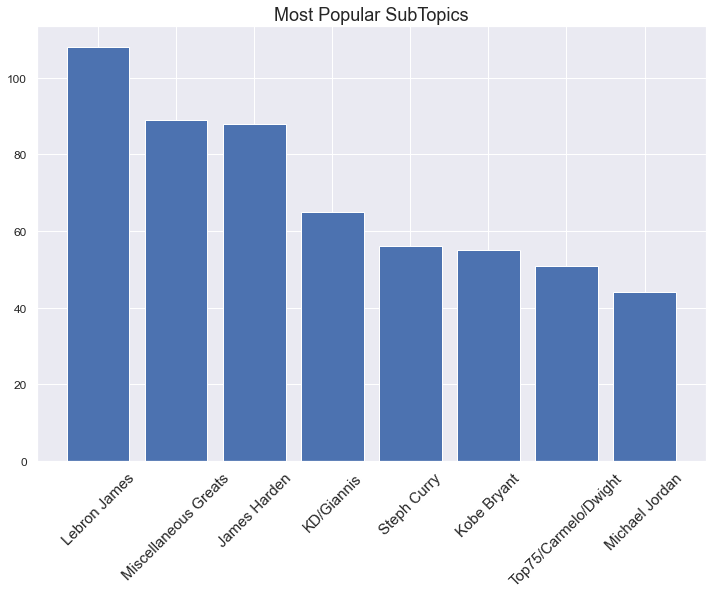

In [425]:
plt.bar(x=top75_topics_ordered.Topic, height=top75_topics_ordered.Count)
plt.title('Most Popular SubTopics', fontsize = 18)
plt.xticks(rotation=45, fontsize = 15)
plt.yticks(size=12)
plt.show()

In [289]:
#New Document Topic Matrix excluding New Ball as main topic
chosen_topics_by_post = nmf_topics_by_post[nmf_topics_by_post.Main_Topic != 'New_Ball']
chosen_topics_by_post

,New_Ball,Streaming,Ben_Simmons,Lakers,Jokic/Morris_Incident,75List,Stats,Kyrie_Irving,Main_Topic
body,,,,,,,,,
bulls manage without jordan one surprising facts suddenly without goat trade compensation bulls outside jordan pippen leading scorer ppg trying imagine warriors playing without curry lebron without cannot see kind success supposed shot jordan young watched back would love insight would rather left list snubbed list reason asking accolade mean much overall mvp selection honestly would rather dwight see fans say sure ad dame situation saying joke made,0.056943,0.000000,0.005005,0.010082,0.000000,0.070338,0.000000,0.007648,75List
center court logo ers,0.014840,0.000000,0.023529,0.000000,0.000000,0.000000,0.007349,0.000000,Ben_Simmons
slyshow kyrie irving supporters trying break barclays center mannix texting league exec monitoring simmons situation sh goes south reacts wants guy,0.000576,0.036104,0.048366,0.000000,0.002048,0.000000,0.000000,0.125284,Kyrie_Irving
league pass commentary,0.000000,0.232550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Streaming
morris fakest tough guy honestly weak always moaning always heat things never way hard foul please biggest strenght hard fouling pretty sad self respect two bad league anyone knows bigger fake tough guy tan two,0.033184,0.027658,0.001719,0.000000,0.042079,0.000000,0.000000,0.000000,Jokic/Morris_Incident
...,...,...,...,...,...,...,...,...,...
celtics ers conversations ben simmons conversations ended ers asked jaylen brown shamscharania mcafee celtics ers conversations ben simmons conversations ended ers asked jaylen brown shamscharania,0.002962,0.000000,0.108332,0.000000,0.000000,0.000000,0.004413,0.000000,Ben_Simmons
league pass question,0.000000,0.309675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000080,Streaming
ward lebron evan mobley one cleveland one source twitter ryanwardla status lebron recognizes talent cleveland new young bigman mobley force cavs posting stat line pts rebs asts stls cleveland indeed get one ryan ward twitter lebron evan mobley one cleveland one,0.016871,0.000000,0.000000,0.000000,0.020642,0.093961,0.022355,0.000000,75List


# Clustering

## T-SNE Original

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


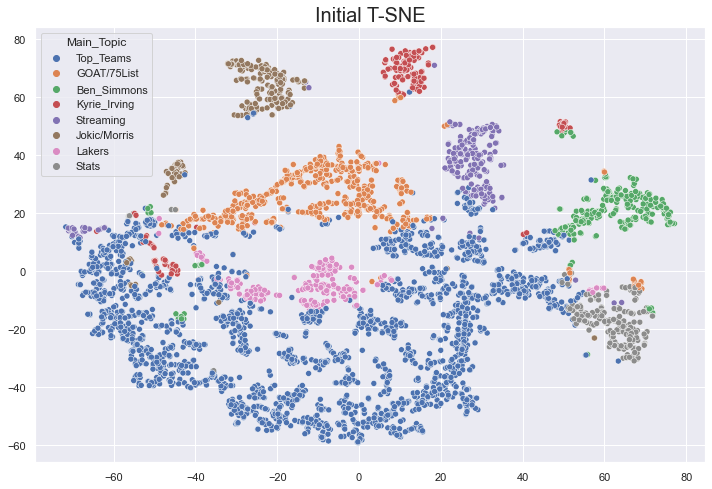

In [434]:
ss = StandardScaler()
tsne_model = TSNE(n_components=2, random_state=0, metric = 'cosine')
tsne_coords = tsne_model.fit_transform(ss.fit_transform(nmf_topics_by_post[['Top_Teams', 'Streaming', 'Ben_Simmons', 'Lakers',
                                            'Jokic/Morris', 'GOAT/75List', 'Stats', 'Kyrie_Irving']]))
viz_df = pd.DataFrame(tsne_coords, columns = ['x', 'y'])
viz_df.index = nmf_topics_by_post.index
viz_df['Main_Topic'] = nmf_topics_by_post['Main_Topic']
sns.set(rc={'figure.figsize':(12,8)})
p = sns.scatterplot(data = viz_df, x='x', y='y', hue = 'Main_Topic') 
p.set_xlabel("")
p.set_ylabel("")
p.set_title('Initial T-SNE', fontsize = 20); 

## T-SNE on 75List

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


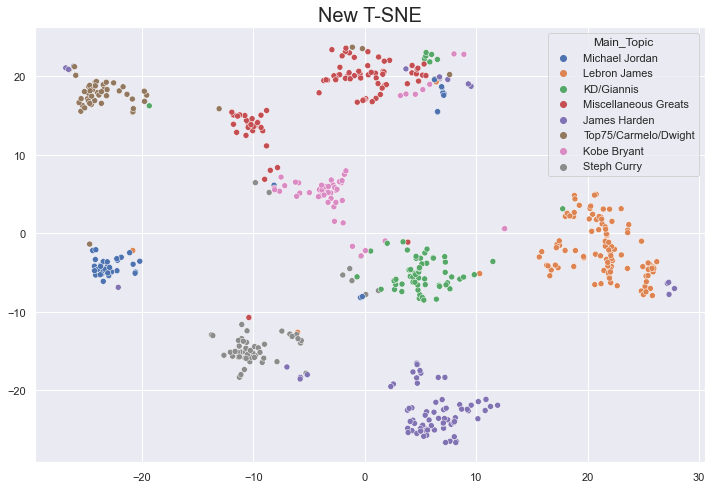

In [433]:
ss = StandardScaler()
tsne_model = TSNE(n_components=2, random_state=0, metric = 'cosine')
tsne_coords = tsne_model.fit_transform(ss.fit_transform(nmf75_topics_by_post[['Lebron James', 'Miscellaneous Greats', 'James Harden', 'KD/Giannis',
                                             'Top75/Carmelo/Dwight', 'Steph Curry', 'Michael Jordan', 'Kobe Bryant']]))
viz_df = pd.DataFrame(tsne_coords, columns = ['x', 'y'])
viz_df.index = nmf75_topics_by_post.index
viz_df['Main_Topic'] = nmf75_topics_by_post['Main_Topic']
sns.set(rc={'figure.figsize':(12,8)})
p = sns.scatterplot(data = viz_df, x='x', y='y', hue = 'Main_Topic')
p.set_xlabel("")
p.set_ylabel("")
p.set_title('New T-SNE', fontsize = 20); 